In [1]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

C:\Users\zuolo\anaconda3\envs\tensor_data_science\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
from common.libs.data_analysis.SeriesDescriberWRTTarget import *
from common.classes.DataGenerators import DataGeneratorSeq
from common.classes.CustomCallbacks import BatchMetricsCallback
from common.libs.CustomScalers import get_log1_scaler


In [3]:
def plot_graph(
        x,
        *ys,
        x_label: str = "x",
        y_label: str = "y",
        jumps: int = 1000,
        labels: list = cycle(['']),
):
    for y, label in zip(ys, chain(labels, cycle(['']))):
        plt.plot(range(len(y)), y, label=label)
    plt.xticks(range(0, len(x), jumps), x[::jumps], rotation=45)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.legend()
    plt.show()


In [4]:
stock_df = pd.read_csv('inputs/hpq.us.txt',
                       delimiter=',',
                       usecols=['Date', 'Open', 'High', 'Low', 'Close'])
print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [5]:
stock_df = stock_df.sort_values('Date')
stock_df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


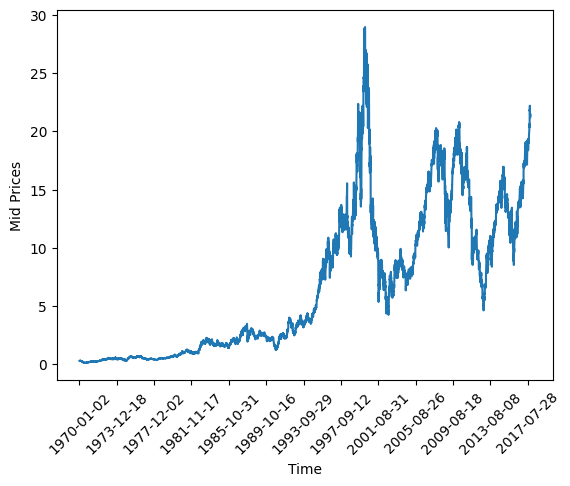

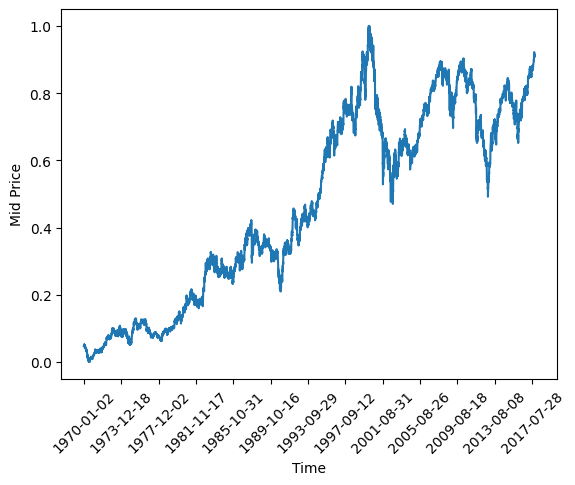

In [6]:
high_prices = stock_df['High'].to_numpy()
low_prices = stock_df['Low'].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0

plot_graph(stock_df['Date'], mid_prices, x_label='Time', y_label='Mid Prices')

train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

train_data = np.expand_dims(train_data, axis=1)
test_data = np.expand_dims(test_data, axis=1)

# Log Scale
log_scaler = get_log1_scaler(validate=True)
train_data = log_scaler.transform(train_data)
test_data = log_scaler.transform(test_data)

# Min Max Scale
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = np.squeeze(scaler.transform(train_data))
test_data = np.squeeze(scaler.transform(test_data))

# Moving average
EMA = 0.0
gamma = 0.1
for ti in range(train_data.shape[0]):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
train_data[ti] = EMA

concatenated_mid_data = np.concatenate((train_data, test_data), axis=0)
plot_graph(stock_df['Date'], concatenated_mid_data, x_label='Time', y_label='Mid Price')

In [7]:
D = 1  # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50  # Number of time steps you look into the future.
batch_size = 200  # Number of samples in a batch
num_nodes = [200, 200, 150]  # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes)  # number of layers
dropout = 0.2  # dropout amount

tf.compat.v1.reset_default_graph()  # This is important in case you run this multiple times


In [8]:
# Input data.
dg = DataGeneratorSeq(train_data, batch_size, num_unrollings)
train_inputs, train_outputs = dg.unroll_batches()

print(train_inputs.shape)
print(train_outputs.shape)

(200, 50, 1)
(200, 1)


In [9]:
layers = [tf.keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2])),
          *[tf.keras.layers.LSTM(
                  num_nodes[layer],
                  return_sequences=(layer < n_layers - 1)
          ) for layer in range(n_layers)],
          tf.keras.layers.Dense(1)]

model = tf.keras.Sequential(layers)

model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='mse',
        metrics=[
            'mae'
        ]
)
# Cant use F1 cuz not categorical data


In [10]:
epochs = 100
dataset = tf.data.Dataset.from_generator(
        dg.as_generator(),
        output_signature=(
            tf.TensorSpec(shape=train_inputs.shape, dtype=tf.float32),
            tf.TensorSpec(shape=train_outputs.shape, dtype=tf.float32)
        )
)
# Train using model.fit with dataset
callback = BatchMetricsCallback()
history = model.fit(
        dataset,
        epochs=epochs,
        steps_per_epoch=1,
        callbacks=[callback],
        verbose=2
)


Epoch 1/100
1/1 - 4s - 4s/step - loss: 0.2550 - mae: 0.4181
Epoch 2/100
1/1 - 1s - 704ms/step - loss: 0.0916 - mae: 0.2462
Epoch 3/100
1/1 - 1s - 537ms/step - loss: 0.0042 - mae: 0.0603
Epoch 4/100
1/1 - 1s - 659ms/step - loss: 0.0757 - mae: 0.2594
Epoch 5/100
1/1 - 1s - 612ms/step - loss: 0.0025 - mae: 0.0432
Epoch 6/100
1/1 - 1s - 677ms/step - loss: 0.0345 - mae: 0.1474
Epoch 7/100
1/1 - 1s - 546ms/step - loss: 0.0431 - mae: 0.1666
Epoch 8/100
1/1 - 1s - 583ms/step - loss: 0.0299 - mae: 0.1356
Epoch 9/100
1/1 - 1s - 566ms/step - loss: 0.0186 - mae: 0.1112
Epoch 10/100
1/1 - 1s - 507ms/step - loss: 0.0040 - mae: 0.0568
Epoch 11/100
1/1 - 1s - 616ms/step - loss: 0.0070 - mae: 0.0784
Epoch 12/100
1/1 - 1s - 615ms/step - loss: 0.0178 - mae: 0.1325
Epoch 13/100
1/1 - 1s - 635ms/step - loss: 0.0164 - mae: 0.1272
Epoch 14/100
1/1 - 1s - 690ms/step - loss: 0.0064 - mae: 0.0765
Epoch 15/100
1/1 - 1s - 664ms/step - loss: 0.0027 - mae: 0.0451
Epoch 16/100
1/1 - 1s - 642ms/step - loss: 0.0063 - 

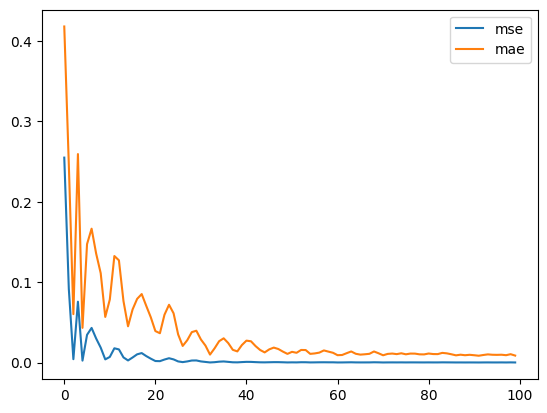

In [11]:
plt.plot(callback.batch_losses, label='mse')
plt.plot(callback.batch_maes, label='mae')
plt.legend()
plt.show()

In [12]:
test_generator = DataGeneratorSeq(test_data, 100, num_unrollings)

test_input, test_output = test_generator.unroll_batches()

test_pred = model.predict(test_input, verbose=0)

loss = tf.keras.losses.mse(test_output, test_pred)
loss = tf.reduce_mean(loss).numpy()
print(loss)

0.0001924275


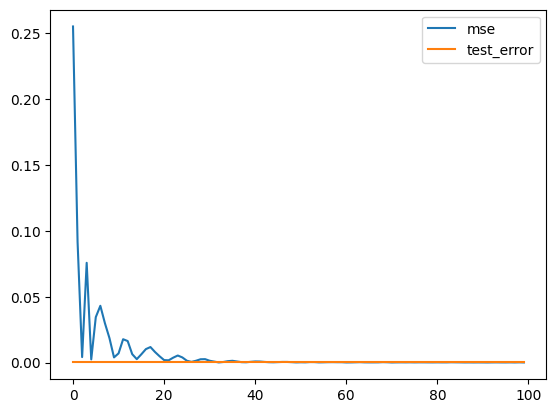

In [13]:
plt.plot(callback.batch_losses, label='mse')
plt.plot([loss] * len(callback.batch_losses), label='test_error')
plt.legend()
plt.show()